In [2]:
import os
import pandas as pd 
import shutil
import configparser
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [3]:
dirCat=r'D:\Sources\COSMOS_photoZ\COSMOS_v3.0\catalogs\forPaper\v05'
fileNameCat=r'05_COSMOS_SpectrZ_Zlim_1p2_AllBands_colors.csv'
idcolumn='Seq'
zspeccolumn='z_spec'
cat=pd.read_csv(os.path.join(dirCat,fileNameCat))

In [9]:
mags=[c for c in cat.columns if 'ap3'  in c]

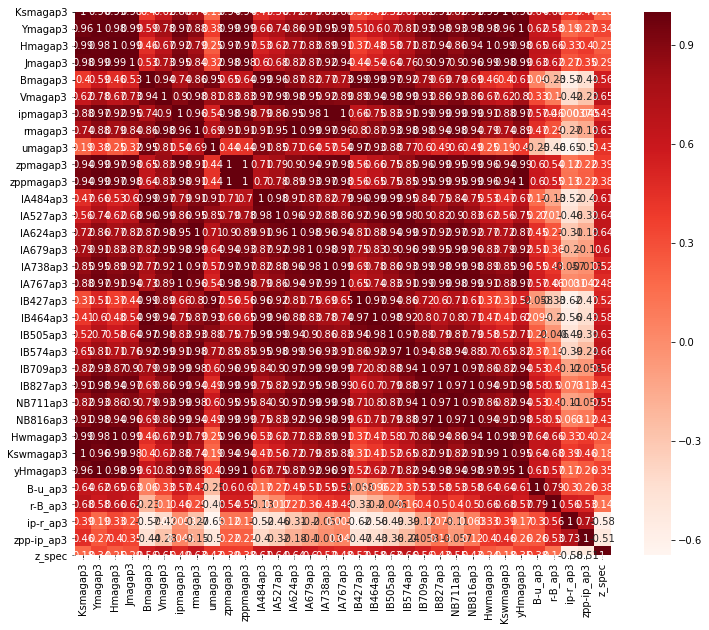

In [14]:
plt.figure(figsize=(12,10))
catWork=cat[mags+[zspeccolumn]]
cor = catWork.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [22]:
cor_target = abs(cor[zspeccolumn])
relSpec = cor_target[cor_target>0.5]
relSpec.sort_values()

zpp-ip_ap3    0.514675
IB427ap3      0.517982
IA738ap3      0.523941
NB711ap3      0.554892
IB709ap3      0.557434
Bmagap3       0.564321
IB464ap3      0.581661
ip-r_ap3      0.584477
IA679ap3      0.595878
IA484ap3      0.606074
rmagap3       0.626740
IB505ap3      0.631686
IA624ap3      0.640768
IA527ap3      0.643980
Vmagap3       0.652767
IB574ap3      0.655189
z_spec        1.000000
Name: z_spec, dtype: float64

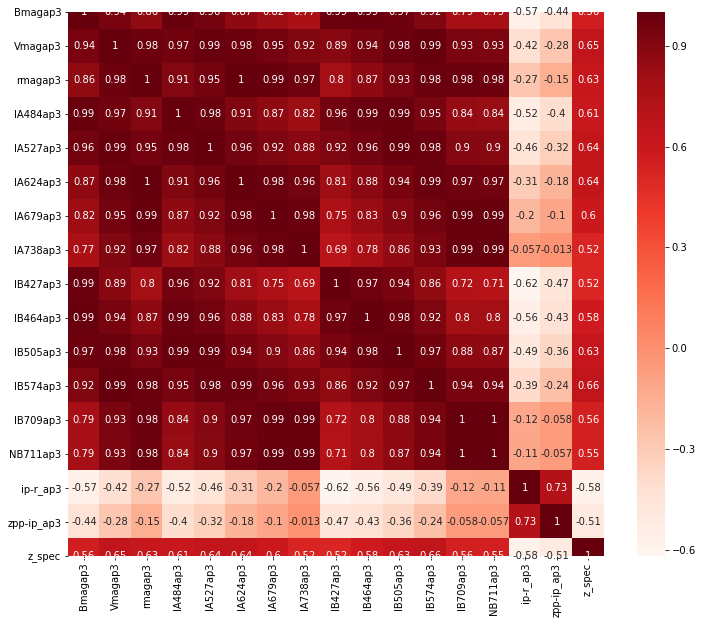

In [18]:
plt.figure(figsize=(12,10))
catWork=cat[relevant_features.index]
corRel = catWork.corr()
sns.heatmap(corRel, annot=True, cmap=plt.cm.Reds)
plt.show()

In [30]:
cor_target = abs(corRel['IB574ap3'])
rel574 = cor_target[cor_target>0.5]

In [32]:
correlations=relSpec.to_frame()
correlations.join(rel574.to_frame()).sort_values(by='IB574ap3')

,z_spec,IB574ap3
z_spec,1.000000,0.655189
IB427ap3,0.517982,0.864200
Bmagap3,0.564321,0.916606
IB464ap3,0.581661,0.920787
IA738ap3,0.523941,0.930300
NB711ap3,0.554892,0.939676
IB709ap3,0.557434,0.943763
IA484ap3,0.606074,0.946870
IA679ap3,0.595878,0.959812
IB505ap3,0.631686,0.967932


In [36]:
## Wrapper methods
import statsmodels.api as sm

In [52]:
X = cat[mags]   #Feature Matrix
Y = cat[zspeccolumn] 

In [53]:
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(Y,X_1).fit()
model.pvalues.sort_values()

C:\Anaconda3\envs\py36\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Hmagap3       1.349537e-276
Ksmagap3      5.362676e-161
r-B_ap3       3.644651e-151
umagap3       4.118317e-118
Vmagap3       9.432499e-106
Ymagap3        2.264128e-60
Bmagap3        1.481391e-46
Hwmagap3       1.769865e-45
zpp-ip_ap3     6.288078e-34
zpmagap3       1.902529e-33
ip-r_ap3       2.572543e-32
NB816ap3       3.470508e-28
rmagap3        3.262389e-23
Kswmagap3      2.168932e-22
zppmagap3      1.459372e-20
IA738ap3       2.300603e-20
IA527ap3       9.317403e-10
yHmagap3       1.409257e-08
NB711ap3       4.743790e-06
IA767ap3       3.913902e-05
IB505ap3       1.829077e-04
IA484ap3       2.655628e-04
Jmagap3        7.636719e-04
IB709ap3       2.168653e-03
B-u_ap3        3.200908e-03
IA679ap3       1.181141e-02
IB427ap3       3.034233e-02
IA624ap3       7.518438e-02
IB464ap3       1.091034e-01
IB827ap3       1.187496e-01
IB574ap3       1.988043e-01
ipmagap3       4.212286e-01
const          8.685236e-01
dtype: float64

In [60]:
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 29)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,Y)  
#Fitting the data to model
model.fit(X_rfe,Y)
print(list(zip(rfe.support_,rfe.ranking_)))

[(True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (False, 3), (False, 4), (True, 1), (False, 2), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1)]


In [55]:
#no of features
nof_list=np.arange(1,len(X.columns))            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 29
Score with 29 features: 0.835323


In [56]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 29)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,Y)  
#Fitting the data to model
model.fit(X_rfe,Y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['Ksmagap3', 'Ymagap3', 'Hmagap3', 'Jmagap3', 'Bmagap3', 'Vmagap3',
       'ipmagap3', 'rmagap3', 'umagap3', 'zpmagap3', 'zppmagap3', 'IA484ap3',
       'IA527ap3', 'IA624ap3', 'IA679ap3', 'IA738ap3', 'IA767ap3', 'IB505ap3',
       'IB709ap3', 'IB827ap3', 'NB711ap3', 'NB816ap3', 'Hwmagap3', 'Kswmagap3',
       'yHmagap3', 'B-u_ap3', 'r-B_ap3', 'ip-r_ap3', 'zpp-ip_ap3'],
      dtype='object')
